In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [3]:
df = pd.read_excel(r"C:\Users\Lenovo\DATOS_IPC.xlsx", parse_dates=['Fecha'], index_col='Fecha')
serie = df['Inflacion']
df.head() 

serie.index = pd.DatetimeIndex(serie.index).to_period("M").to_timestamp()
serie = serie.asfreq("MS")

In [4]:
#identificación
#Prieba ADF
adf_test = adfuller(serie)
print("Prueba ADF:")
print(f" Estadístico ADF: {adf_test[0]:.4f}")
print(f" p-valor: {adf_test[1]:.4f}")
print(" Valores críticos:", adf_test[4])

Prueba ADF:
 Estadístico ADF: -2.6881
 p-valor: 0.0761
 Valores críticos: {'1%': -3.458128284586202, '5%': -2.873761835239286, '10%': -2.5732834559706235}


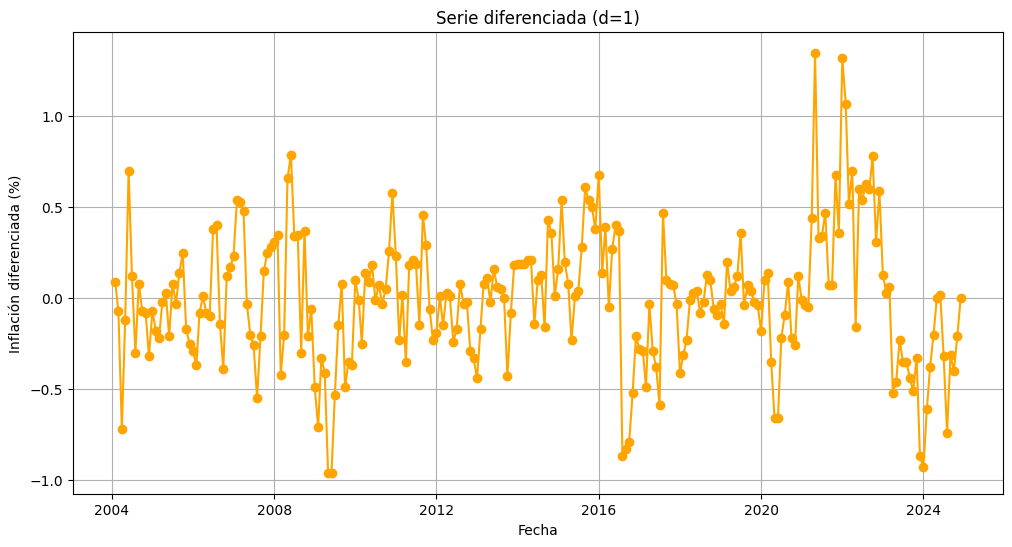

In [5]:
# 1. Diferenciación de la serie (d=1)
serie_diff = serie.diff().dropna()

plt.figure(figsize=(12,6))
plt.plot(serie_diff, marker='o', linestyle='-', color="orange")
plt.title("Serie diferenciada (d=1)")
plt.xlabel("Fecha")
plt.ylabel("Inflación diferenciada (%)")
plt.grid(True)
plt.savefig("serie diferenciada.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Prueba ADF sobre la serie diferenciada
adf_test_diff = adfuller(serie_diff)
print("Prueba ADF sobre serie diferenciada (d=1):")
print(f" Estadístico ADF: {adf_test_diff[0]}")
print(f" p-valor: {adf_test_diff[1]}")
print("Valores críticos:", adf_test_diff[4])

Prueba ADF sobre serie diferenciada (d=1):
 Estadístico ADF: -4.211882623167407
 p-valor: 0.0006290390462698629
Valores críticos: {'1%': -3.458128284586202, '5%': -2.873761835239286, '10%': -2.5732834559706235}


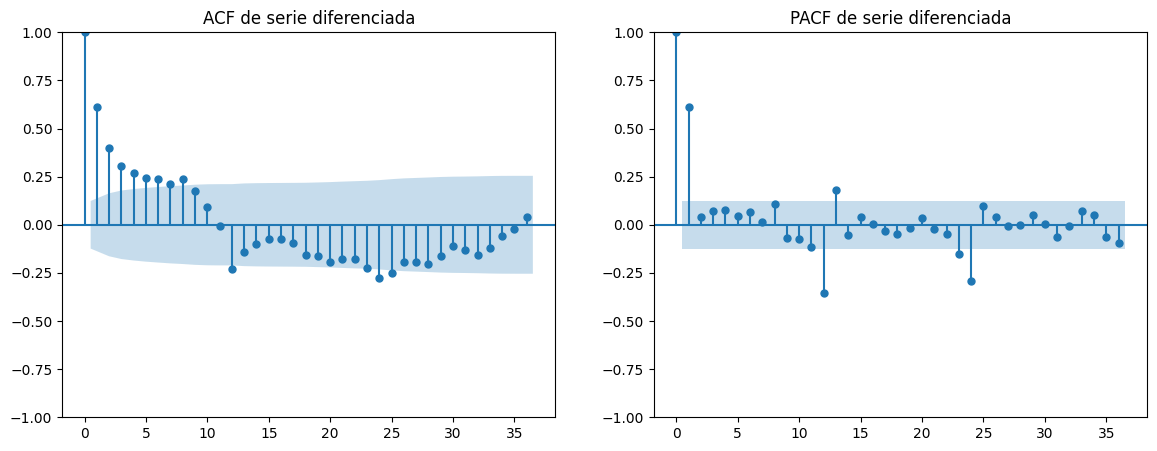

In [7]:
# Gráficos ACF y PACF d=1
fig, ax = plt.subplots(1, 2, figsize=(14,5))

plot_acf(serie_diff, ax=ax[0], lags=36)
ax[0].set_title("ACF de serie diferenciada")

plot_pacf(serie_diff, ax=ax[1], lags=36, method='ywm')
ax[1].set_title("PACF de serie diferenciada")
plt.savefig("ACF Y PACF arima.png", dpi=300, bbox_inches='tight')
plt.show()

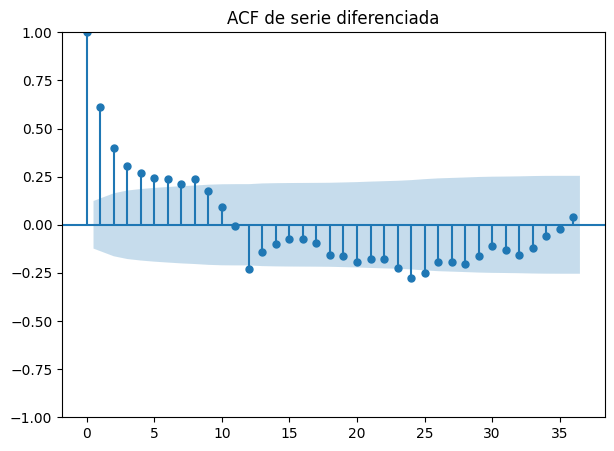

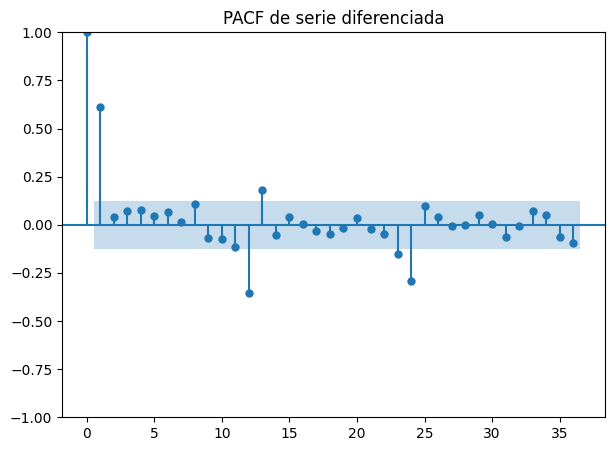

In [8]:
#ACF
fig1, ax1 = plt.subplots(figsize=(7,5))
plot_acf(serie_diff, ax=ax1, lags=36)
ax1.set_title("ACF de serie diferenciada")
fig1.savefig("ACF_serie_diferenciada.png", dpi=300, bbox_inches='tight')
plt.show()

#PACF
fig2, ax2 = plt.subplots(figsize=(7,5))
plot_pacf(serie_diff, ax=ax2, lags=36, method='ywm')
ax2.set_title("PACF de serie diferenciada")
fig2.savefig("PACF_serie_diferenciada.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# Selección automática de parámetros ARIMA
modelo_auto = pm.auto_arima(
    serie,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=1,              
    seasonal=False,   
    stepwise=True,
    suppress_warnings=True,
    information_criterion='aic'
)

print("Modelo sugerido por auto_arima:")
print(modelo_auto.summary())

C:\Users\Lenovo\arima_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Lenovo\arima_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Lenovo\arima_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Lenovo\arima_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Lenovo\arima_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Us

Modelo sugerido por auto_arima:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -46.239
Date:                Fri, 03 Oct 2025   AIC                             96.477
Time:                        06:23:24   BIC                            103.528
Sample:                    01-01-2004   HQIC                            99.315
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6093      0.046     13.223      0.000       0.519       0.700
sigma2         0.0845      0.005     15.470      0.000       0.074       0.095
Ljung-Box (L1) (Q): 

In [10]:
#Estimación
# Extraer el orden (p,d,q) sugerido por auto_arima
p, d, q = modelo_auto.order
print(f"Modelo sugerido: ARIMA({p},{d},{q})")

# Ajustar modelo en statsmodels
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(serie, order=(p, d, q))
resultado = modelo.fit()

print("\nResumen del modelo:")
print(resultado.summary())


Modelo sugerido: ARIMA(1,1,0)

Resumen del modelo:
                               SARIMAX Results                                
Dep. Variable:              Inflacion   No. Observations:                  252
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -46.239
Date:                Fri, 03 Oct 2025   AIC                             96.477
Time:                        06:23:24   BIC                            103.528
Sample:                    01-01-2004   HQIC                            99.315
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6093      0.046     13.223      0.000       0.519       0.700
sigma2         0.0845      0.005     15.470      0.000       0.074       0.095
L

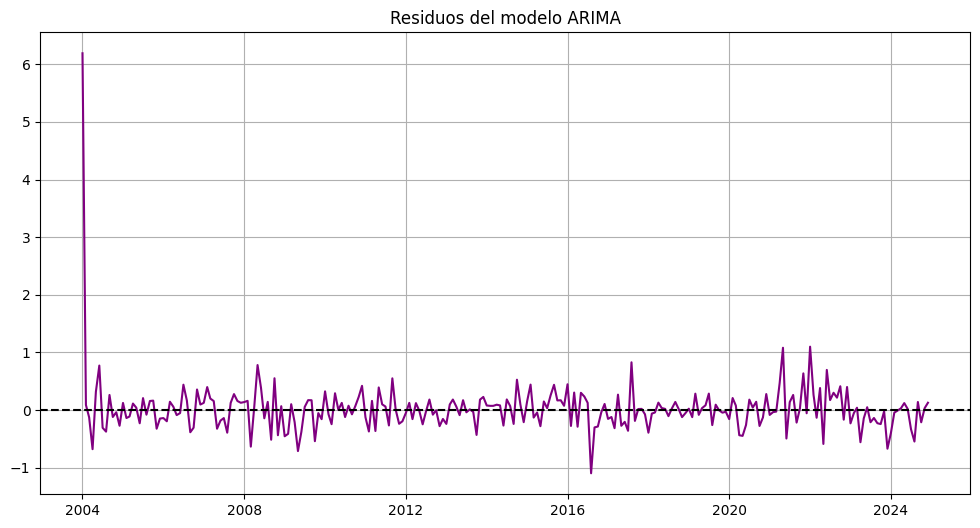

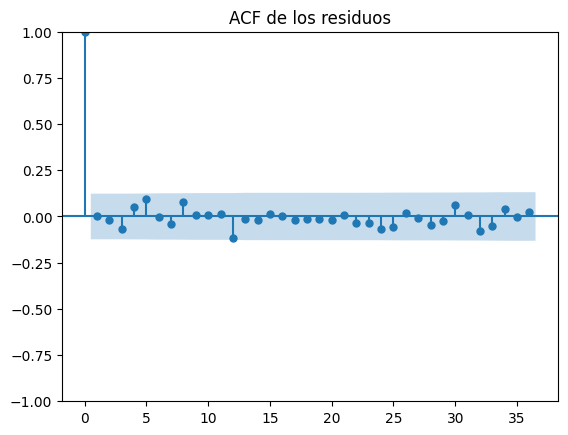


Prueba de Ljung-Box (lag=12):
     lb_stat  lb_pvalue
12  9.926117   0.622442


In [11]:
# DIAGNÓSTICO

residuos = resultado.resid

# Gráfico de residuos
plt.figure(figsize=(12,6))
plt.plot(residuos, color="purple")
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Residuos del modelo ARIMA")
plt.grid(True)
plt.savefig("grafico residuos.png", dpi=300, bbox_inches='tight')
plt.show()

# ACF de residuos
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuos, lags=36)
plt.savefig("ACF Residuos.png", dpi=300, bbox_inches='tight')
plt.title("ACF de los residuos")

plt.show()

# Prueba de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuos, lags=[12], return_df=True)
print("\nPrueba de Ljung-Box (lag=12):")
print(lb_test)

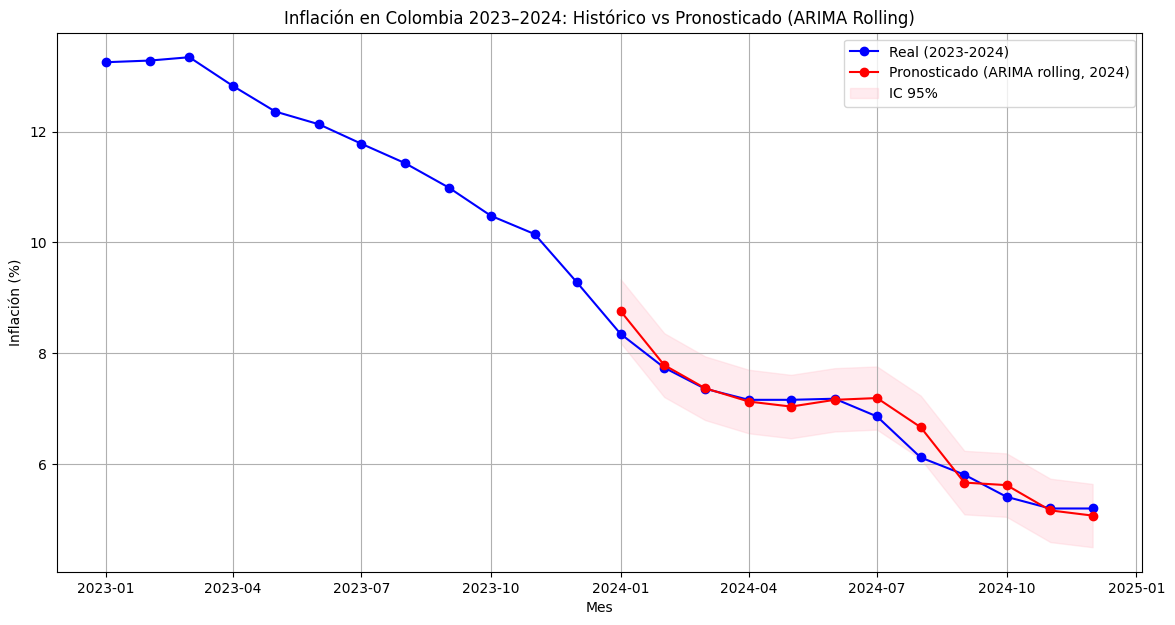

In [12]:
# Rolling-step
train = serie.loc[:'2023-12-01']
test = serie.loc['2024-01-01':]

modelo = ARIMA(train, order=(p,d,q))
resultado = modelo.fit()

predicciones = []
indices = []
lower_bounds = []
upper_bounds = []


for fecha_real in test.index:

    pred = resultado.get_forecast(steps=1)
    mean_pred = pred.predicted_mean.iloc[0]
    conf_int = pred.conf_int(alpha=0.05).iloc[0]

    predicciones.append(mean_pred)
    indices.append(fecha_real)
    lower_bounds.append(conf_int["lower Inflacion"])
    upper_bounds.append(conf_int["upper Inflacion"])
    
    train = pd.concat([train, serie.loc[[fecha_real]]])
    
    # Reajustar modelo
    modelo = ARIMA(train, order=(p,d,q))
    resultado = modelo.fit()

df_backtest = pd.DataFrame({
    "Real": test.values,
    "Pronosticado": predicciones,
    "IC_lower": lower_bounds,
    "IC_upper": upper_bounds
}, index=indices)

plt.figure(figsize=(14,7))

plt.plot(serie.loc['2023-01-01':'2024-12-01'].index,
         serie.loc['2023-01-01':'2024-12-01'].values,
         marker="o", color="blue", label="Real (2023-2024)")

plt.plot(df_backtest.index, df_backtest["Pronosticado"],
         marker="o", color="red", label="Pronosticado (ARIMA rolling, 2024)")

plt.fill_between(df_backtest.index, 
                 df_backtest["IC_lower"], 
                 df_backtest["IC_upper"], 
                 color="pink", alpha=0.3, label="IC 95%")

plt.title("Inflación en Colombia 2023–2024: Histórico vs Pronosticado (ARIMA Rolling)")
plt.xlabel("Mes")
plt.ylabel("Inflación (%)")
plt.legend()
plt.grid(True)
plt.savefig("Rolling.png", dpi=300, bbox_inches='tight')
plt.show()


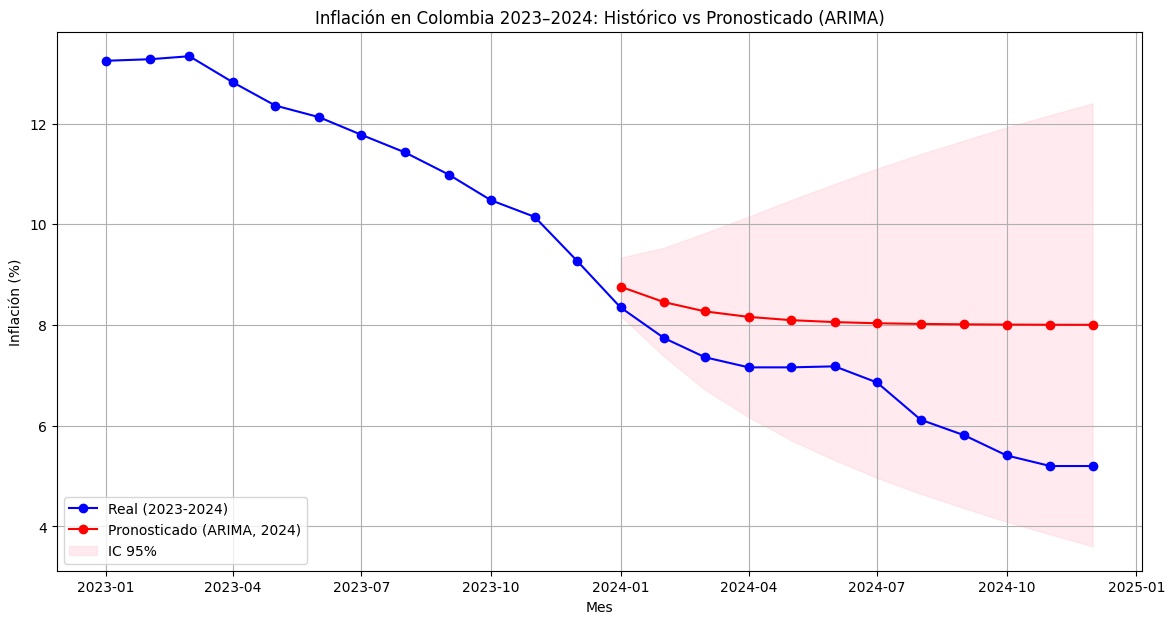

In [13]:
# Multi-step
train = serie.loc[:'2023-12-01']

modelo = ARIMA(train, order=(p, d, q))
resultado = modelo.fit()

forecast_2024 = resultado.get_forecast(steps=12)

mean_pred = forecast_2024.predicted_mean
conf_int = forecast_2024.conf_int(alpha=0.05)

fechas_2024 = pd.date_range(start='2024-01-01', periods=12, freq='MS')

df_forecast = pd.DataFrame({
    "Real": serie.loc['2024-01-01':],  
    "Pronosticado": mean_pred.values,
    "IC_lower": conf_int.iloc[:,0].values,
    "IC_upper": conf_int.iloc[:,1].values
}, index=fechas_2024)

plt.figure(figsize=(14,7))


plt.plot(serie.loc['2023-01-01':'2024-12-01'].index,
         serie.loc['2023-01-01':'2024-12-01'].values,
         marker="o", color="blue", label="Real (2023-2024)")


plt.plot(df_forecast.index, df_forecast["Pronosticado"],
         marker="o", color="red", label="Pronosticado (ARIMA, 2024)")


plt.fill_between(df_forecast.index, 
                 df_forecast["IC_lower"], 
                 df_forecast["IC_upper"], 
                 color="pink", alpha=0.3, label="IC 95%")

plt.title("Inflación en Colombia 2023–2024: Histórico vs Pronosticado (ARIMA)")
plt.xlabel("Mes")
plt.ylabel("Inflación (%)")
plt.legend()
plt.grid(True)
plt.savefig("Sin Rolling.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Rolling-step
mae = mean_absolute_error(df_backtest["Real"], df_backtest["Pronosticado"])
rmse = np.sqrt(mean_squared_error(df_backtest["Real"], df_backtest["Pronosticado"]))
mape = np.mean(np.abs((df_backtest["Real"] - df_backtest["Pronosticado"]) / df_backtest["Real"])) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 0.1696
RMSE: 0.2379
MAPE: 2.61%


In [15]:
# Multi-step
mae = mean_absolute_error(df_forecast["Real"], df_forecast["Pronosticado"])
rmse = np.sqrt(mean_squared_error(df_forecast["Real"], df_forecast["Pronosticado"]))
mape = np.mean(np.abs((df_forecast["Real"] - df_forecast["Pronosticado"]) / df_forecast["Real"])) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 1.5292
RMSE: 1.7447
MAPE: 25.67%
